# Neural Networks in Python


In this notebook we will present a flexible object oriented codebase for a feed forward neural network, along with a demonstration of how to use it. Before we get into the details of the neural network, we will first present some implementations of various schedulers, cost functions and activation functions that can be used together with the neural network.

## I. Schedulers
The code below shows object oriented implementations of the Constant, Momentum, Adagrad, AdagradMomentum, RMS prop and Adam schedulers. All of the classes belong to the shared abstract Scheduler class, and share the update_change() and reset() methods allowing for any of the schedulers to be seamlessly used during the training stage, as will later be shown in the fit() method of the neural network. Update_change() only has one parameter, the gradient ($δ^l_ja^{l−1}_k$), and returns the change which will be subtracted from the weights. The reset() function takes no parameters, and resets the desired variables. For Constant and Momentum, reset does nothing.

In [1]:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

### Usage of schedulers
To initalize a scheduler, simply create the object and pass in the necessary parameters such as the learning rate and the momentum as shown below. As the Scheduler class is an abstract class it should not called directly, and will raise an error upon usage.

In [2]:
momentum_scheduler = Momentum(eta=1e-3, momentum=0.9)
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

Here is a small example for how a segment of code using schedulers could look. This code works for any scheduler.

In [3]:
weights = np.ones((3,3))
print(f"Before scheduler:\n{weights=}")

epochs = 10
for e in range(epochs):
    gradient = np.random.rand(3, 3)
    change = adam_scheduler.update_change(gradient)
    weights = weights - change
    adam_scheduler.reset()

print(f"\nAfter scheduler:\n{weights=}")

Before scheduler:
weights=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

After scheduler:
weights=array([[0.993993  , 0.99399301, 0.99401572],
       [0.99399302, 0.993993  , 0.99399301],
       [0.993993  , 0.99399301, 0.99399301]])


## II. Cost functions
In this section we will quickly look at the cost functions that can be used when creating the neural network. Every cost function takes the target vector as its parameter, and returns a function valued only at X such that it may easily be differentiated.

In [4]:
import autograd.numpy as np

def CostOLS(target):
    
    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func


def CostLogReg(target):

    def func(X):
        
        return -(1.0 / target.shape[0]) * np.sum(
            (target * np.log(X + 10e-10)) + ((1 - target) * np.log(1 - X + 10e-10))
        )

    return func


def CostCrossEntropy(target):
    
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))

    return func

### Usage of cost functions
Below we will provide a short example of how these cost function may be used to obtain results if you wish to test them out on your own using AutoGrad's automatics differentiation.

In [5]:
from autograd import grad

target = np.array([[1, 2, 3]]).T
a = np.array([[4, 5, 6]]).T

cost_func = CostCrossEntropy
cost_func_derivative = grad(cost_func(target))

valued_at_a = cost_func_derivative(a)
print(f"Derivative of cost function {cost_func.__name__} valued at a:\n{valued_at_a}")

Derivative of cost function CostCrossEntropy valued at a:
[[-0.08333333]
 [-0.13333333]
 [-0.16666667]]


## III. Activation functions
Finally, before we look at the neural network, we will look at the activation functions which can be specified between the hidden layers and as the output function. Each function can be valued for any given vector or matrix X, and can be differentiated via derivate().

In [6]:
import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)

### Usage of activation functions
Below is a short demonstration of how to use an activation function. The derivative of the activation function will be important when calculating the output delta term during backpropagation.  Note that derivate() can also be used for cost functions for a more generalized approach.

In [7]:
z = np.array([[4, 5, 6]]).T
print(f"Input to activation function:\n{z}")

act_func = sigmoid
a = act_func(z)
print(f"\nOutput from {act_func.__name__} activation function:\n{a}")

act_func_derivative = derivate(act_func)
valued_at_z = act_func_derivative(a)
print(f"\nDerivative of {act_func.__name__} activation function valued at z:\n{valued_at_z}")

Input to activation function:
[[4]
 [5]
 [6]]

Output from sigmoid activation function:
[[0.98201379]
 [0.99330715]
 [0.99752738]]

Derivative of sigmoid activation function valued at z:
[[0.19824029]
 [0.19721923]
 [0.19683648]]


## IV. The Neural Network
Now that we have gotten a good understanding of the implementation of some important components, we can take a look at an object oriented implementation of a feed forward neural network. The feed forward neural network has been implemented as a class named FFNN, which can be initiated as a regressor or classifier dependant on the choice of cost function. The FFNN can have any number of input nodes, hidden layers with any amount of hidden nodes, and any amount of output nodes meaning it can perform multiclass classification as well as binary classification and regression problems. Although there is a lot of code present, it makes for an easy to use and generalizeable interface for creating many types of neural networks as will be demonstrated below.

In [8]:
import math
import autograd.numpy as np
import sys
import warnings
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy, copy
from typing import Tuple, Callable
from sklearn.utils import resample

warnings.simplefilter("error")


class FFNN:
    """
    Description:
    ------------
        Feed Forward Neural Network with interface enabling flexible design of a
        nerual networks architecture and the specification of activation function
        in the hidden layers and output layer respectively. This model can be used
        for both regression and classification problems, depending on the output function.

    Attributes:
    ------------
        I   dimensions (tuple[int]): A list of positive integers, which specifies the
            number of nodes in each of the networks layers. The first integer in the array
            defines the number of nodes in the input layer, the second integer defines number
            of nodes in the first hidden layer and so on until the last number, which
            specifies the number of nodes in the output layer.
        II  hidden_func (Callable): The activation function for the hidden layers
        III output_func (Callable): The activation function for the output layer
        IV  cost_func (Callable): Our cost function
        V   seed (int): Sets random seed, makes results reproducible
    """

    def __init__(
        self,
        dimensions: tuple[int],
        hidden_func: Callable = sigmoid,
        output_func: Callable = lambda x: x,
        cost_func: Callable = CostOLS,
        seed: int = None,
    ):
        self.dimensions = dimensions
        self.hidden_func = hidden_func
        self.output_func = output_func
        self.cost_func = cost_func
        self.seed = seed
        self.weights = list()
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.a_matrices = list()
        self.z_matrices = list()
        self.classification = None

        self.reset_weights()
        self._set_classification()

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        scheduler: Scheduler,
        batches: int = 1,
        epochs: int = 100,
        lam: float = 0,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ):
        """
        Description:
        ------------
            This function performs the training the neural network by performing the feedforward and backpropagation
            algorithm to update the networks weights.

        Parameters:
        ------------
            I    X (np.ndarray) : training data
            II   t (np.ndarray) : target data
            III  scheduler (Scheduler) : specified scheduler (algorithm for optimization of gradient descent)
            IV   scheduler_args (list[int]) : list of all arguments necessary for scheduler

        Optional Parameters:
        ------------
            V    batches (int) : number of batches the datasets are split into, default equal to 1
            VI   epochs (int) : number of iterations used to train the network, default equal to 100
            VII  lam (float) : regularization hyperparameter lambda
            VIII X_val (np.ndarray) : validation set
            IX   t_val (np.ndarray) : validation target set

        Returns:
        ------------
            I   scores (dict) : A dictionary containing the performance metrics of the model.
                The number of the metrics depends on the parameters passed to the fit-function.

        """

        # setup 
        if self.seed is not None:
            np.random.seed(self.seed)

        val_set = False
        if X_val is not None and t_val is not None:
            val_set = True

        # creating arrays for score metrics
        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        self.schedulers_weight = list()
        self.schedulers_bias = list()

        batch_size = X.shape[0] // batches

        X, t = resample(X, t)

        # this function returns a function valued only at X
        cost_function_train = self.cost_func(t)
        if val_set:
            cost_function_val = self.cost_func(t_val)

        # create schedulers for each weight matrix
        for i in range(len(self.weights)):
            self.schedulers_weight.append(copy(scheduler))
            self.schedulers_bias.append(copy(scheduler))

        print(f"{scheduler.__class__.__name__}: Eta={scheduler.eta}, Lambda={lam}")

        try:
            for e in range(epochs):
                for i in range(batches):
                    # allows for minibatch gradient descent
                    if i == batches - 1:
                        # If the for loop has reached the last batch, take all thats left
                        X_batch = X[i * batch_size :, :]
                        t_batch = t[i * batch_size :, :]
                    else:
                        X_batch = X[i * batch_size : (i + 1) * batch_size, :]
                        t_batch = t[i * batch_size : (i + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(X_batch, t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for scheduler in self.schedulers_weight:
                    scheduler.reset()

                for scheduler in self.schedulers_bias:
                    scheduler.reset()

                # computing performance metrics
                pred_train = self.predict(X)
                train_error = cost_function_train(pred_train)

                train_errors[e] = train_error
                if val_set:
                    
                    pred_val = self.predict(X_val)
                    val_error = cost_function_val(pred_val)
                    val_errors[e] = val_error

                if self.classification:
                    train_acc = self._accuracy(self.predict(X), t)
                    train_accs[e] = train_acc
                    if val_set:
                        val_acc = self._accuracy(pred_val, t_val)
                        val_accs[e] = val_acc

                # printing progress bar
                progression = e / epochs
                print_length = self._progress_bar(
                    progression,
                    train_error=train_errors[e],
                    train_acc=train_accs[e],
                    val_error=val_errors[e],
                    val_acc=val_accs[e],
                )
        except KeyboardInterrupt:
            # allows for stopping training at any point and seeing the result
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            1,
            train_error=train_errors[e],
            train_acc=train_accs[e],
            val_error=val_errors[e],
            val_acc=val_accs[e],
        )
        sys.stdout.write("")

        # return performance metrics for the entire run
        scores = dict()

        scores["train_errors"] = train_errors

        if val_set:
            scores["val_errors"] = val_errors

        if self.classification:
            scores["train_accs"] = train_accs

            if val_set:
                scores["val_accs"] = val_accs

        return scores

    def predict(self, X: np.ndarray, *, threshold=0.5):
        """
         Description:
         ------------
             Performs prediction after training of the network has been finished.

         Parameters:
        ------------
             I   X (np.ndarray): The design matrix, with n rows of p features each

         Optional Parameters:
         ------------
             II  threshold (float) : sets minimal value for a prediction to be predicted as the positive class
                 in classification problems

         Returns:
         ------------
             I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
                 This vector is thresholded if regression=False, meaning that classification results
                 in a vector of 1s and 0s, while regressions in an array of decimal numbers

        """

        predict = self._feedforward(X)

        if self.classification:
            return np.where(predict > threshold, 1, 0)
        else:
            return predict

    def reset_weights(self):
        """
        Description:
        ------------
            Resets/Reinitializes the weights in order to train the network for a new problem.

        """
        if self.seed is not None:
            np.random.seed(self.seed)

        self.weights = list()
        for i in range(len(self.dimensions) - 1):
            weight_array = np.random.randn(
                self.dimensions[i] + 1, self.dimensions[i + 1]
            )
            weight_array[0, :] = np.random.randn(self.dimensions[i + 1]) * 0.01

            self.weights.append(weight_array)

    def _feedforward(self, X: np.ndarray):
        """
        Description:
        ------------
            Calculates the activation of each layer starting at the input and ending at the output.
            Each following activation is calculated from a weighted sum of each of the preceeding
            activations (except in the case of the input layer).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each

        Returns:
        ------------
            I   z (np.ndarray): A prediction vector (row) for each row in our design matrix
        """

        # reset matrices
        self.a_matrices = list()
        self.z_matrices = list()

        # if X is just a vector, make it into a matrix
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))

        # Add a coloumn of zeros as the first coloumn of the design matrix, in order
        # to add bias to our data
        bias = np.ones((X.shape[0], 1)) * 0.01
        X = np.hstack([bias, X])

        # a^0, the nodes in the input layer (one a^0 for each row in X - where the
        # exponent indicates layer number).
        a = X
        self.a_matrices.append(a)
        self.z_matrices.append(a)

        # The feed forward algorithm
        for i in range(len(self.weights)):
            if i < len(self.weights) - 1:
                z = a @ self.weights[i]
                self.z_matrices.append(z)
                a = self.hidden_func(z)
                # bias column again added to the data here
                bias = np.ones((a.shape[0], 1)) * 0.01
                a = np.hstack([bias, a])
                self.a_matrices.append(a)
            else:
                try:
                    # a^L, the nodes in our output layers
                    z = a @ self.weights[i]
                    a = self.output_func(z)
                    self.a_matrices.append(a)
                    self.z_matrices.append(z)
                except Exception as OverflowError:
                    print(
                        "OverflowError in fit() in FFNN\nHOW TO DEBUG ERROR: Consider lowering your learning rate or scheduler specific parameters such as momentum, or check if your input values need scaling"
                    )

        # this will be a^L
        return a

    def _backpropagate(self, X: np.ndarray, t: np.ndarray, lam: float):
        """
        Description:
        ------------
            Performs the backpropagation algorithm. In other words, this method
            calculates the gradient of all the layers starting at the
            output layer, and moving from right to left accumulates the gradient until
            the input layer is reached. Each layers respective weights are updated while
            the algorithm propagates backwards from the output layer (auto-differentation in reverse mode).

        Parameters:
        ------------
            I   X (np.ndarray): The design matrix, with n rows of p features each.
            II  t (np.ndarray): The target vector, with n rows of p targets.
            III lam (float32): regularization parameter used to punish the weights in case of overfitting

        Returns:
        ------------
            No return value.

        """
        out_derivative = derivate(self.output_func)
        hidden_derivative = derivate(self.hidden_func)

        for i in range(len(self.weights) - 1, -1, -1):
            # delta terms for output
            if i == len(self.weights) - 1:
                # for multi-class classification
                if (
                    self.output_func.__name__ == "softmax"
                ):
                    delta_matrix = self.a_matrices[i + 1] - t
                # for binary classification
                else:
                    cost_func_derivative = grad(self.cost_func(t))
                    delta_matrix = out_derivative(
                        self.z_matrices[i + 1]
                    ) * cost_func_derivative(self.a_matrices[i + 1])

            # delta terms for hidden layer
            else:
                delta_matrix = (
                    self.weights[i + 1][1:, :] @ delta_matrix.T
                ).T * hidden_derivative(self.z_matrices[i + 1])

            # calculate gradient
            gradient_weights = self.a_matrices[i][:, 1:].T @ delta_matrix
            gradient_bias = np.sum(delta_matrix, axis=0).reshape(
                1, delta_matrix.shape[1]
            )

            # regularization term
            gradient_weights += self.weights[i][1:, :] * lam

            # use scheduler
            update_matrix = np.vstack(
                [
                    self.schedulers_bias[i].update_change(gradient_bias),
                    self.schedulers_weight[i].update_change(gradient_weights),
                ]
            )

            # update weights and bias
            self.weights[i] -= update_matrix

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray):
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): vector of predicitons output network
                (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network ideally should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))
    
    def _set_classification(self):
        """
        Description:
        ------------
            Decides if FFNN acts as classifier (True) og regressor (False),
            sets self.classification during init()
        """
        self.classification = False
        if (
            self.cost_func.__name__ == "CostLogReg"
            or self.cost_func.__name__ == "CostCrossEntropy"
        ):
            self.classification = True

    def _progress_bar(self, progression, **kwargs):
        """
        Description:
        ------------
            Displays progress of training
        """
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._format(progression * 100, decimals=5)
        line = f"  {bar} {perc_print}% "

        for key in kwargs:
            if not np.isnan(kwargs[key]):
                value = self._format(kwargs[key], decimals=4)
                line += f"| {key}: {value} "
        sys.stdout.write("\r" + line)
        sys.stdout.flush()
        return len(line)

    def _format(self, value, decimals=4):
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= decimals - 1:
            return str(round(value))
        return f"{value:.{decimals-n-1}f}"




## Usage of neural networks
This section will show how to initiate and use various different neural networks.

### Linear regression
 Before we make a model, we will quickly generate a dataset we can use for our linear regression problem as shown below:

In [9]:
import autograd.numpy as np
from sklearn.model_selection import train_test_split

def SkrankeFunction(x, y):
    return np.ravel(0 + 1*x + 2*y + 3*x**2 + 4*x*y + 5*y**2)

def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y**k)

    return X

step=0.2
x = np.arange(0, 1, step)
y = np.arange(0, 1, step)
x, y = np.meshgrid(x, y)
target = SkrankeFunction(x, y)
target = target.reshape(target.shape[0], 1)

poly_degree=3
X = create_X(x, y, poly_degree)

X_train, X_test, t_train, t_test = train_test_split(X, target)

In [24]:
print(X_train.shape, t_train.shape)

(426, 30) (426, 1)


Now that we have our dataset ready for the regression, we can create our regressor. Note that with the seed parameter, we can make sure our results stay the same every time we run the neural network. For inititialization, we simply specify the dimensions (we wish the amount of input nodes to be equal to the datapoints, and the output to predict one value).

In [11]:
input_nodes = X_train.shape[1]
output_nodes = 1

linear_regression = FFNN((input_nodes, output_nodes), output_func=identity, cost_func=CostOLS, seed=2023)

We then fit our model with our training data using the scheduler of our choice.

In [12]:
linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Constant(eta=1e-2)
scores = linear_regression.fit(X_train, t_train, scheduler)

Constant: Eta=0.01, Lambda=0
  [=======================================>] 100.0% | train_error: 2.11 

Due to the progress bar we can see the MSE (train_error) throughout the FFNN's training. Note that the fit() function has some optional parameters with defualt arguments. For example, the regularization hyperparameter can be left ignored if not needed, and equally the FFNN will by default run for 100 epochs. These can easily be changed, such as for example:

In [13]:
linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scores = linear_regression.fit(X_train, t_train, scheduler, lam=1e-3, epochs=1000)

Constant: Eta=0.01, Lambda=0.001
  [=======================================>] 100.0% | train_error: 0.0312 

We see that given more epochs to train on, the regressor reaches a lower training MSE. If we want to use our test data, we simply pass it into our predict function.

In [14]:
pred_test = linear_regression.predict(X_test)

print(f"Prediction of test data:\n{pred_test}\n")
print(f"Target values of test data:\n{t_test}\n")
print(f"test MSE:\n{CostOLS(t_test)(pred_test)}")

Prediction of test data:
[[8.11933242]
 [6.57621007]
 [3.13662589]
 [6.03188532]
 [2.22597104]
 [2.16715206]
 [3.6795256 ]]

Target values of test data:
[[7.64]
 [6.96]
 [3.  ]
 [6.12]
 [1.68]
 [2.24]
 [3.8 ]]

test MSE:
0.10305576953209486


### Binary classification
Let us load in a binary classification dataset, here the Wisconsin Cancer data set, and follow a similar setup to the regression case. We will create a logistic regression classifier, and a feed forward neural network with 2 hidden layers.

In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

wisconsin = load_breast_cancer()
X = wisconsin.data
target = wisconsin.target
target = target.reshape(target.shape[0], 1)

X_train, X_val, t_train, t_val = train_test_split(X, target)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [16]:
input_nodes = X_train.shape[1]
output_nodes = 1

logistic_regression = FFNN((input_nodes, output_nodes), output_func=sigmoid, cost_func=CostLogReg, seed=2023)

We will now make use of our validation data by passing it into our fit function as a keyword argument

In [17]:
logistic_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)
scores = logistic_regression.fit(X_train, t_train, scheduler, epochs=500, X_val=X_val, t_val=t_val)

Adam: Eta=0.001, Lambda=0
  [=======================================>] 100.0% | train_error: 14.0 | train_acc: 0.324 | val_error: 12.8 | val_acc: 0.385  

Finally, we will create a neural network with 2 hidden layers with activation functions. We will also make use of the 'batches' keyword argument to run stochastic gradient descent by specifying a number of batches we wish to split our data into.

In [18]:
input_nodes = X_train.shape[1]
hidden_nodes1 = 100
hidden_nodes2 = 30
output_nodes = 1

dims = (input_nodes, hidden_nodes1, hidden_nodes2, output_nodes)

neural_network = FFNN(dims, hidden_func=RELU, output_func=sigmoid, cost_func=CostLogReg, seed=2023)

In [19]:
neural_network.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999)
scores = neural_network.fit(X_train, t_train, scheduler, batches=10, epochs=300, X_val=X_val, t_val=t_val)

Adam: Eta=0.0001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.195 | train_acc: 0.991 | val_error: 1.74 | val_acc: 0.916  

To plot the results, simply use the dictionary returned by the fit function

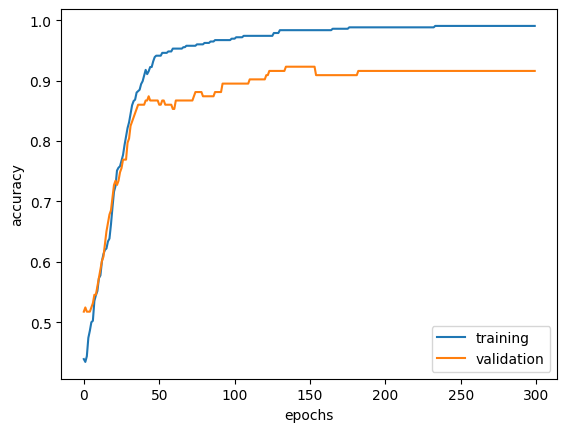

In [20]:
import matplotlib.pyplot as plt

plt.plot(scores["train_accs"], label="training")
plt.plot(scores["val_accs"], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Multiclass classification
Finally, we will demonstrate the use case of multiclass classification using our FFNN with the famous MNIST dataset, which contain images of digits between the range of 0 to 9. The MNIST dataset has 64 features.

In [21]:
from sklearn.datasets import load_digits

def onehot(target: np.ndarray):
    onehot = np.zeros((target.size, target.max() + 1))
    onehot[np.arange(target.size), target] = 1
    return onehot

digits = load_digits()

X = digits.data
target = digits.target
target = onehot(target)

In [22]:
input_nodes = 64
hidden_nodes1 = 100
hidden_nodes2 = 30
output_nodes = 10

dims = (input_nodes, hidden_nodes1, hidden_nodes2, output_nodes)

multiclass = FFNN(dims, hidden_func=LRELU, output_func=softmax, cost_func=CostCrossEntropy)

In [23]:
multiclass.reset_weights() # reset weights such that previous runs or reruns don't affect the weights

scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999)
scores = multiclass.fit(X, target, scheduler, epochs=1000)

Adam: Eta=0.0001, Lambda=0
  [=======================================>] 100.0% | train_error: 0.178 | train_acc: 0.983 

A quick note to finish on is that the different demonstrations that were made such as sending in the test data using predict for linear regression can as easily be done for a binary or multi class classification problem, and the same goes for vice versa for plotting different scores over epochs.